# Taller 2

MINE-4101: Ciencia de Datos Aplicada
Universidad de los Andes  
Ivan Ricardo Saavedra Villamil 201016001

  
Última actualización: 2 octubre, 2022

# Problema

Predecir el número de usuarios promedio por día del nuevo servicio de patinetas, al mismo tiempo de poder entender la importancia y relación de las
variables consideradas.

## Diccionario de Datos
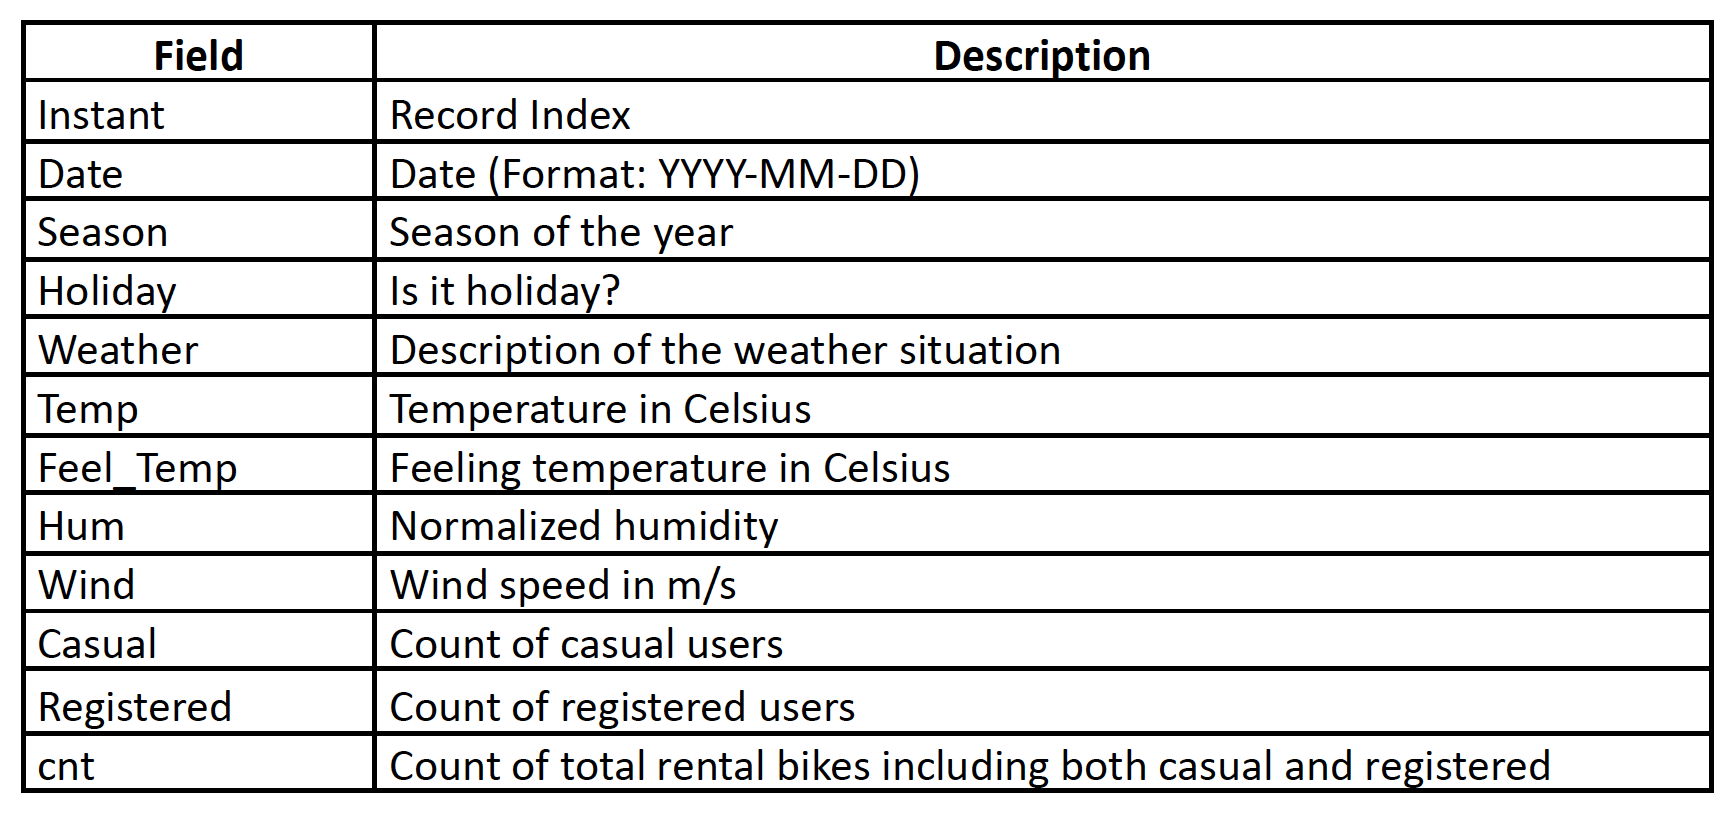

# Inicialización y cargue de los datos

In [1]:
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importando librerías

import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport

In [4]:
# Cargando los datos históricos de los inmuebles
df = pd.read_csv('https://raw.githubusercontent.com/ivanrsv85/taller2/main/Data_Taller_2.csv', sep = ';', on_bad_lines='skip')

In [5]:
# Mostrando las dimensiones del dataframe de los datos históricos de los inmuebles
df.shape

(731, 12)

In [6]:
# Mostrando el tipo de las columnas del dataframe de los datos históricos de los inmuebles
df.dtypes

instant        int64
Date          object
Season        object
Holiday       object
Weather       object
Temp          object
Feel_Temp     object
Hum           object
Wind          object
Casual         int64
Registered     int64
cnt            int64
dtype: object

In [7]:
# Mostrando las primeras filas del dataframe de los datos históricos de los inmuebles
df.head()

instant       Date    Season Holiday            Weather      Temp  \
0        1  1/01/2020  Springer      No      Mist + Cloudy  8,175849   
1        2  2/01/2020  Springer      No      Mist + Cloudy  9,083466   
2        3  3/01/2020  Springer      No         Few clouds  1,229108   
3        4  4/01/2020  Springer      No         Few clouds       1,4   
4        5  5/01/2020  Springer      No   Partly    cloudy  2,666979   

  Feel_Temp       Hum        Wind  Casual  Registered   cnt  
0  9,090375  0,805833   10,749882     331         654   985  
1  8,625733  0,696087  -16,652113     131         670   801  
2  0,902035  0,437273   16,636703     120        1229  1349  
3  1,969734  0,590435   10,739832     108        1454  1562  
4   2,77569  0,436957     12,5223      82        1518  1600

# Limpieza de datos, correción de valores y creación de variables

Además de la limpieza, y corrección de valores, se crearon 3 features nuevas: Weekday, Month y Weather group. Weekday trae el día de la semana, Month trae el nombre del mes y Weather group agrupa en menor cantidad de categorías a la feature Weather.

## Date

In [8]:
# Creando una expresión lambda para transformar todos los valores de la feature date
dateparse = lambda x: datetime.strptime(x, "%d/%m/%Y")

In [106]:
# Aplicando la función
df['Date'] = df["Date"].apply(dateparse)

KeyError: ignored

Uno o varios registros no me permiten correr la función

In [10]:
# Creando una función para encontrar los registros que no me dejan correr la función
def error_in_format(x):
    try:
        datetime.strptime(x, "%d/%m/%Y")
        return False
    except:
        return True

In [11]:
# Usando la función para identificar los registros
df.loc[df["Date"].apply(error_in_format)]

instant        Date    Season Holiday Weather      Temp Feel_Temp  \
424      425  29/02/2021  Springer      No    Mist  8,184356   8,37809   

          Hum       Wind  Casual  Registered   cnt  
424  0,804783  12,000839      65        1769  1834

El registro con instant = 425 no está bien escrito porque dice que es el 29/02/2021 y esta fecha no existe, asumimos que querían escribir 28/02/2021

In [12]:
# Reemplazando 29/02/2021 por 28/02/2021
df["Date"] = df["Date"].replace(['29/02/2021'],['28/02/2021'])

In [13]:
# Aplicando la función
df['Date'] = df["Date"].apply(dateparse)

In [14]:
# Comprobando transformación de la fecha a formato fecha
df.dtypes

instant                int64
Date          datetime64[ns]
Season                object
Holiday               object
Weather               object
Temp                  object
Feel_Temp             object
Hum                   object
Wind                  object
Casual                 int64
Registered             int64
cnt                    int64
dtype: object

In [15]:
# Creando la feature día de la semana
df['Weekday'] = df["Date"].dt.day_name()

In [16]:
# Creando la feature mes
df['Month'] = df["Date"].dt.month_name()

## Season

In [17]:
# Encontrando los valores únicos de la feature: Season
df["Season"].unique()

array(['Springer', 'Summer', 'Fall', 'Winter'], dtype=object)

In [18]:
# Reemplazando Springer por Spring
df["Season"] = df["Season"].replace(['Springer'],['Spring'])

In [19]:
# Comprobando la transformación
df["Season"].unique()

array(['Spring', 'Summer', 'Fall', 'Winter'], dtype=object)

## Holiday

In [20]:
# Encontrando los valores únicos de la feature: Holiday
df["Holiday"].unique()

array(['No', 'Yes'], dtype=object)

In [21]:
# Reemplazar 29/02/2021 por 28/02/2021
df["Holiday"] = df["Holiday"].replace(['No', 'Yes'],[0, 1])

In [22]:
# Comprobando la transformación
df["Holiday"].unique()

array([0, 1])

## Weather

In [23]:
# Encontrando los valores únicos de la feature: Holiday
df["Weather"].unique()

array(['Mist + Cloudy', 'Few clouds', ' Partly    cloudy', 'Clear',
       'Mist', 'Mist + Broken clouds', ' Partly cloudy',
       'Mist + Few clouds', 'Rain + Thunderstorm',
       'Light Rain + Scattered clouds', 'Snow'], dtype=object)

In [24]:
# Creando una función para reagrupar la feature Weather

def regroup_weather(x):
  if 'Mist' in x:
    weather_group = 'Mist'
    return weather_group
  elif 'Rain' in x:
    weather_group = 'Rain'
    return weather_group
  else:
    weather_group = 'Other'
    return weather_group

In [25]:
# Creando la feature Weather group
df['Weather group'] = df['Weather'].apply(regroup_weather)

## Temp

In [26]:
# Reemplazando vacíos por 0
df['Temp'] = df['Temp'].fillna('0')

In [27]:
# Transformando feature Temp de string a float
def str_to_float(x):            
    if ',' in x:                      
        x = x.replace(',', '.')
        return float(x)
    else:                           
        return float(x)

df['Temp'] = df['Temp'].apply(str_to_float)

In [28]:
# Encontrando el rango de los valores de la feature: Temp
df["Temp"].describe(percentiles = [.25, .5, .75, .95, .99])

count    731.000000
mean      15.187500
std        8.646189
min       -5.220871
25%        7.725424
50%       15.265000
75%       22.765425
95%       28.131250
99%       30.822000
max       32.498349
Name: Temp, dtype: float64

## Feel_Temp

In [29]:
# Transformando feature Feel_Temp de string a float
df['Feel_Temp'] = df['Feel_Temp'].apply(str_to_float)

In [30]:
# Encontrando el rango de los valores de la feature: Feel_Temp
df["Feel_Temp"].describe(percentiles = [.25, .5, .75, .95, .99])

count    731.000000
mean      14.294637
std        7.659175
min       -4.283729
25%        7.878597
50%       14.876451
75%       20.604294
95%       25.603449
99%       28.593589
max       31.522112
Name: Feel_Temp, dtype: float64

## Hum

In [31]:
# Transformando feature Hum de string a float
df['Hum'] = df['Hum'].apply(str_to_float)

In [32]:
# Encontrando el rango de los valores de la feature: Hum
df["Hum"].describe(percentiles = [.25, .5, .75, .95, .99])

count    731.000000
mean       0.682614
std        0.750679
min        0.000000
25%        0.522291
50%        0.629167
75%        0.732708
95%        0.876932
99%        0.949186
max       10.867083
Name: Hum, dtype: float64

In [33]:
# Transformando los valores de la feature Hum
def fix_hum(x):
  if x > 10:
    x = x-10
    return x
  else: 
    return x

df['Hum'] = df['Hum'].apply(fix_hum)

In [34]:
# Comprobando la transformación
df["Hum"].describe(percentiles = [.25, .5, .75, .95, .99])

count    731.000000
mean       0.627894
std        0.142429
min        0.000000
25%        0.520000
50%        0.626667
75%        0.730209
95%        0.868541
99%        0.927917
max        0.972500
Name: Hum, dtype: float64

## Wind

In [35]:
# Transformando feature Wind de string a float
df['Wind'] = df['Wind'].apply(str_to_float)

In [36]:
# Encontrando el rango de los valores de la feature: Wind
df["Wind"].describe(percentiles = [.25, .5, .75, .95, .99])

count    731.000000
mean      12.668792
std        5.417463
min      -16.652113
25%        9.000746
50%       12.124789
75%       15.624802
95%       22.999961
99%       27.379697
max       34.000021
Name: Wind, dtype: float64

#Análisis univariado y bivariado

## Análisis bivariado

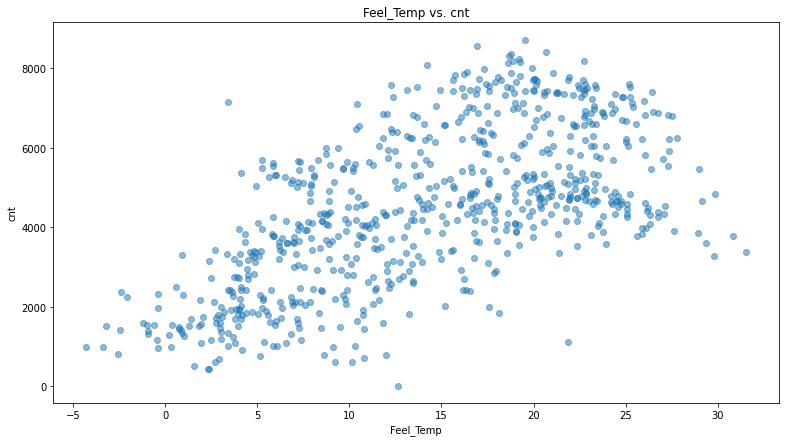

In [37]:
# Graficando un scatter plot para 2 variables cuantitativas
plt.figure(figsize = (13, 7))
plt.scatter(df['Feel_Temp'], df['cnt'], alpha = 0.5)
plt.title('Feel_Temp vs. cnt')
plt.xlabel('Feel_Temp')
plt.ylabel('cnt')
plt.show()

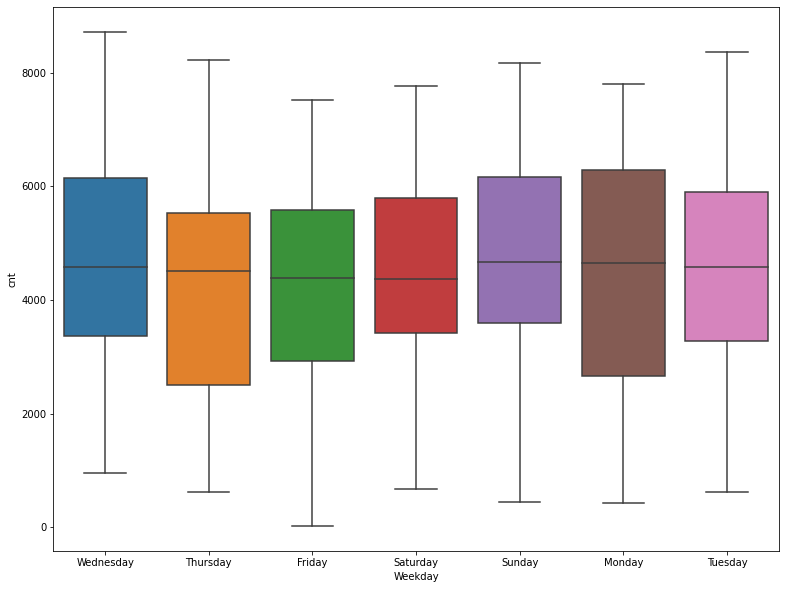

In [38]:
# Graficando cnt por Weekday
plt.figure(figsize = (13, 10))
sns.boxplot(x = 'Weekday', y = 'cnt', data = df)

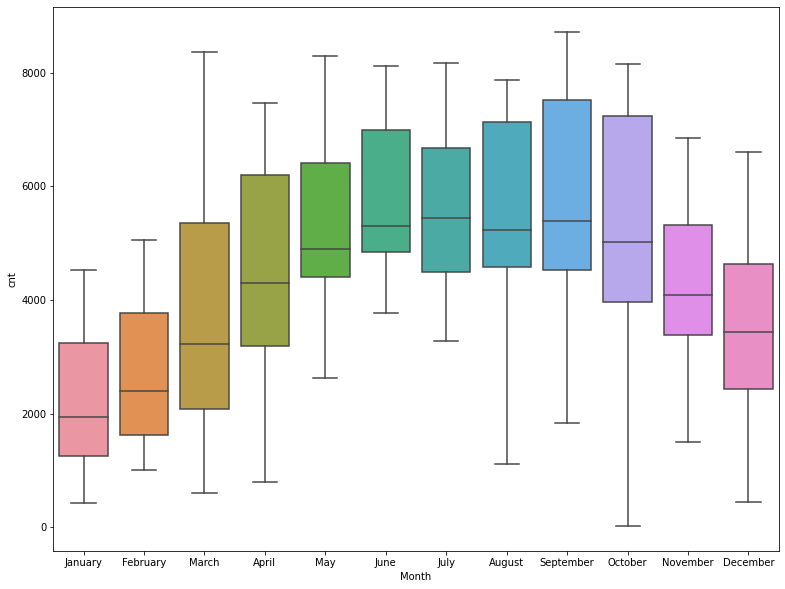

In [39]:
# Graficando cnt por Month
plt.figure(figsize = (13, 10))
sns.boxplot(x = 'Month', y = 'cnt', data = df)

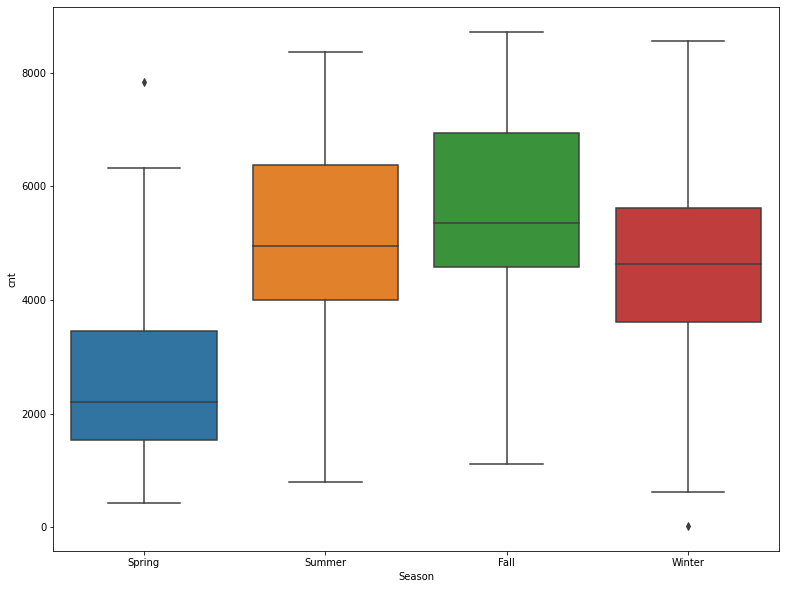

In [40]:
# Graficando cnt por Season
plt.figure(figsize = (13, 10))
sns.boxplot(x = 'Season', y = 'cnt', data = df)

## Perfilando los datos del dataframe

In [41]:
# Obteniendo las principales estadísticas del dataframe
df.describe()

instant     Holiday        Temp   Feel_Temp         Hum        Wind  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean   366.000000    0.028728   15.187500   14.294637    0.627894   12.668792   
std    211.165812    0.167155    8.646189    7.659175    0.142429    5.417463   
min      1.000000    0.000000   -5.220871   -4.283729    0.000000  -16.652113   
25%    183.500000    0.000000    7.725424    7.878597    0.520000    9.000746   
50%    366.000000    0.000000   15.265000   14.876451    0.626667   12.124789   
75%    548.500000    0.000000   22.765425   20.604294    0.730209   15.624802   
max    731.000000    1.000000   32.498349   31.522112    0.972500   34.000021   

            Casual   Registered          cnt  
count   731.000000   731.000000   731.000000  
mean    848.176471  3656.172367  4504.348837  
std     686.622488  1560.256377  1937.211452  
min       2.000000    20.000000    22.000000  
25%     315.500000  2497.000000  3152.000000  
50%     713.000000  3662.000000  4548.000000  
75%    1096.000000  4776.500000  5956.000000  
max    3410.000000  6946.000000  8714.000000

In [42]:
profile = ProfileReport(df)

In [43]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Transformando variables categoricas

In [44]:
# Eliminando features que no se van a usar
del df["instant"]
del df["Date"]
del df["Season"]
del df["Weather"]

In [45]:
# Transformando variables categóricas
df = pd.get_dummies(df, drop_first = True)

In [46]:
df.head()

Holiday      Temp  Feel_Temp       Hum       Wind  Casual  Registered  \
0        0  8.175849   9.090375  0.805833  10.749882     331         654   
1        0  9.083466   8.625733  0.696087 -16.652113     131         670   
2        0  1.229108   0.902035  0.437273  16.636703     120        1229   
3        0  1.400000   1.969734  0.590435  10.739832     108        1454   
4        0  2.666979   2.775690  0.436957  12.522300      82        1518   

    cnt  Weekday_Monday  Weekday_Saturday  ...  Month_January  Month_July  \
0   985               0                 0  ...              1           0   
1   801               0                 0  ...              1           0   
2  1349               0                 0  ...              1           0   
3  1562               0                 1  ...              1           0   
4  1600               0                 0  ...              1           0   

   Month_June  Month_March  Month_May  Month_November  Month_October  \
0           0            0          0               0              0   
1           0            0          0               0              0   
2           0            0          0               0              0   
3           0            0          0               0              0   
4           0            0          0               0              0   

   Month_September  Weather group_Other  Weather group_Rain  
0                0                    0                   0  
1                0                    0                   0  
2                0                    1                   0  
3                0                    1                   0  
4                0                    1                   0  

[5 rows x 27 columns]

# Analizando la feature objetivo

In [47]:
# Analizando la feature objetivo 
df['cnt'].describe(percentiles = [.25, .5, .75, .95, .99])

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
95%      7576.000000
99%      8163.700000
max      8714.000000
Name: cnt, dtype: float64

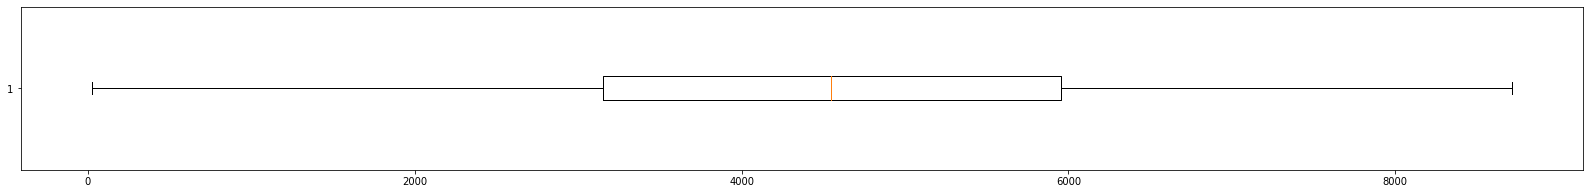

In [48]:
# Graficando la distribución la feature objetivo
plt.figure(figsize = (28, 3))
plt.boxplot(df['cnt'], vert = False)
plt.show()

# Features para entrenar el modelo

Se eligen las variables que pueden explicar a la variable objetivo y se descarta: Date por estar representada por la variables Weekday y Month; Se descarta Season para usar Month; Se cambia Weahter por Weather group; Se descarta Casual y Registered porque son otra forma de ver la variable objetivo   

In [49]:
features = ['Holiday', 'Temp', 'Feel_Temp', 'Hum', 'Wind', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weather group_Other', 'Weather group_Rain', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September']

In [50]:
df[features + ['cnt']].corr()

Holiday      Temp  Feel_Temp       Hum      Wind  \
Holiday              1.000000 -0.026512  -0.032507 -0.015937  0.009009   
Temp                -0.026512  1.000000   0.976974  0.122903 -0.147906   
Feel_Temp           -0.032507  0.976974   1.000000  0.139988 -0.171659   
Hum                 -0.015937  0.122903   0.139988  1.000000 -0.244995   
Wind                 0.009009 -0.147906  -0.171659 -0.244995  1.000000   
Weekday_Monday      -0.046599  0.032994   0.028106  0.015157  0.000098   
Weekday_Saturday     0.142197  0.008858   0.005744  0.032678 -0.020407   
Weekday_Sunday      -0.047084  0.028232   0.025169 -0.000377 -0.008194   
Weekday_Thursday    -0.070435 -0.028096  -0.030543 -0.013024 -0.000544   
Weekday_Tuesday     -0.046599  0.012131   0.011003 -0.026407 -0.009441   
Weekday_Wednesday   -0.023734 -0.017263  -0.019728 -0.039618  0.009473   
Weather group_Other  0.026073  0.099693   0.102616 -0.548058  0.031964   
Weather group_Rain  -0.024893 -0.025747  -0.032639  0.212875  0.068786   
Month_August        -0.052356  0.341954   0.331105  0.021038 -0.060915   
Month_December       0.006434 -0.282943  -0.277030  0.081590 -0.047010   
Month_February       0.011072 -0.307085  -0.311832 -0.123468  0.095725   
Month_January        0.035829 -0.425431  -0.438476 -0.089973  0.034657   
Month_July           0.006434  0.418221   0.429469 -0.064204 -0.086758   
Month_June          -0.051427  0.310271   0.300943 -0.109435 -0.013569   
Month_March         -0.052356 -0.170254  -0.172731 -0.084312  0.126639   
Month_May            0.006434  0.167994   0.170689  0.130608 -0.022973   
Month_November       0.067917 -0.201914  -0.196468 -0.006340 -0.031758   
Month_October        0.006434 -0.013809  -0.004451  0.140880 -0.052297   
Month_September      0.008245  0.200291   0.192704  0.182404 -0.105893   
cnt                 -0.068348  0.623141   0.631066 -0.100659 -0.214097   

                     Weekday_Monday  Weekday_Saturday  Weekday_Sunday  \
Holiday                   -0.046599          0.142197       -0.047084   
Temp                       0.032994          0.008858        0.028232   
Feel_Temp                  0.028106          0.005744        0.025169   
Hum                        0.015157          0.032678       -0.000377   
Wind                       0.000098         -0.020407       -0.008194   
Weekday_Monday             1.000000         -0.164938       -0.166798   
Weekday_Saturday          -0.164938          1.000000       -0.165862   
Weekday_Sunday            -0.166798         -0.165862        1.000000   
Weekday_Thursday          -0.166798         -0.165862       -0.167732   
Weekday_Tuesday           -0.165869         -0.164938       -0.166798   
Weekday_Wednesday         -0.166798         -0.165862       -0.167732   
Weather group_Other        0.010412          0.007515        0.013286   
Weather group_Rain         0.051542         -0.003149        0.050772   
Month_August               0.016575          0.003726        0.015321   
Month_December            -0.011537         -0.010387       -0.012678   
Month_February            -0.001598         -0.000461        0.011821   
Month_January             -0.011537          0.003726        0.001321   
Month_July                -0.011537          0.003726       -0.012678   
Month_June                 0.006616         -0.006506       -0.008787   
Month_March                0.016575         -0.010387        0.001321   
Month_May                  0.002519          0.017839        0.015321   
Month_November             0.020883         -0.006506        0.005424   
Month_October             -0.011537          0.017839        0.001321   
Month_September           -0.007651         -0.006506       -0.008787   
cnt                        0.020914         -0.005664        0.034722   

                     Weekday_Thursday  Weekday_Tuesday  ...  Month_February  \
Holiday                     -0.070435        -0.046599  ...        0.011072   
Temp                        -0.028096   

# Separando los datasets de entreno y de prueba

In [51]:
X = df[features]

In [52]:
Y = df['cnt']

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [54]:
X_train.shape

(584, 24)

In [55]:
X_test.shape

(147, 24)

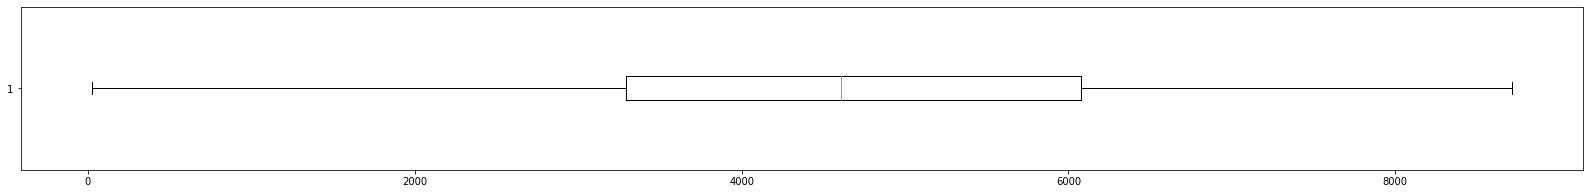

In [56]:
plt.figure(figsize = (28, 3))
plt.boxplot(Y_train, vert = False)
plt.show()

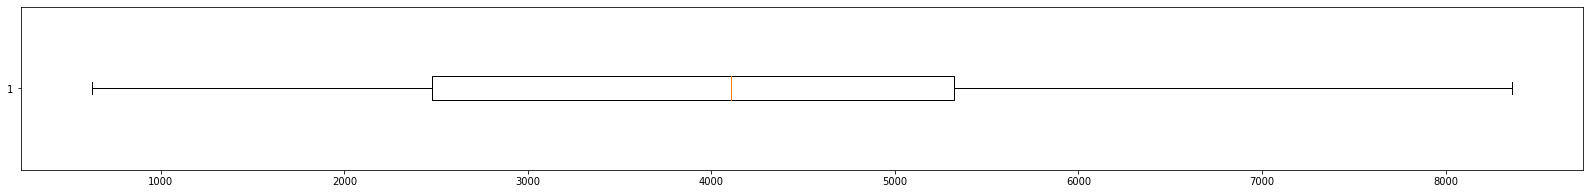

In [57]:
plt.figure(figsize = (28, 3))
plt.boxplot(Y_test, vert = False)
plt.show()

# Estandarizando features

In [58]:
scaler = StandardScaler()

In [59]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenando el modelos

A continuación presentamos los modelos implementados. De acuerdo a los resultados podemos concluir que el modelo que se debe presentar a la alcaldía es la **regresión lineal** porque es el modelo que menor RMSE tanto en el grupo de datos de entrenamiento como en el grupo de datos de prueba, los cuales son 1300.4 y 1265.9 respectivamente. Si comparamos estos errores con la media de la variable objetivo que es 4504.3, encontraremos que estos errores son aceptables por lo que podemos concluir que este modelo es muy preciso para predecir la variable objetivo. Entre los otros modelos el único que se acercan al nivel de error de la regresión lineal es el polinomial grado 2 con regularización ridge, si bien este modelo arroja un RMSE de solo 912 en los datos de entrenamiento, en los datos de prueba el RMSE sube a 1788 por lo que descartamos este modelo.

## Regresión lineal

### Entrenamiento

In [60]:
regr = LinearRegression()

In [61]:
regr.fit(X_train_scaled, Y_train)

LinearRegression()

In [62]:
regr.coef_

array([ -76.48191383,  330.11142194,  724.10341425, -537.33160635,
       -275.9272322 ,   50.96692671,   -7.31855513,   62.86899211,
        -40.35720354,   45.37705839,   91.65621573,   31.00761442,
       -244.56436984,  -90.89504292,  -41.35577288, -311.85058621,
       -332.10717753, -265.94151315, -108.83383814,  -98.43616562,
          4.24213194,   46.63610986,  193.63960684,  171.06791512])

In [63]:
regr.intercept_

4595.313356164384

### Evaluando el modelo

In [64]:
preds_train = regr.predict(X_train_scaled)
preds_test = regr.predict(X_test_scaled)

In [65]:
mean_absolute_error(Y_train, preds_train), mean_absolute_error(Y_test, preds_test)

(1122.9079044249254, 1072.906315954007)

In [66]:
np.sqrt(mean_squared_error(Y_train, preds_train)), np.sqrt(mean_squared_error(Y_test, preds_test))

(1300.4910056650094, 1265.9151064496739)

### Analisis del error 

In [67]:
(Y_test - preds_test).describe(percentiles = [.25, .5, .75, .95, .99])

count     147.000000
mean     -230.752408
std      1248.961964
min     -3793.467505
25%     -1102.293261
50%      -345.163410
75%       851.929911
95%      1652.463075
99%      2246.284126
max      3240.111399
Name: cnt, dtype: float64

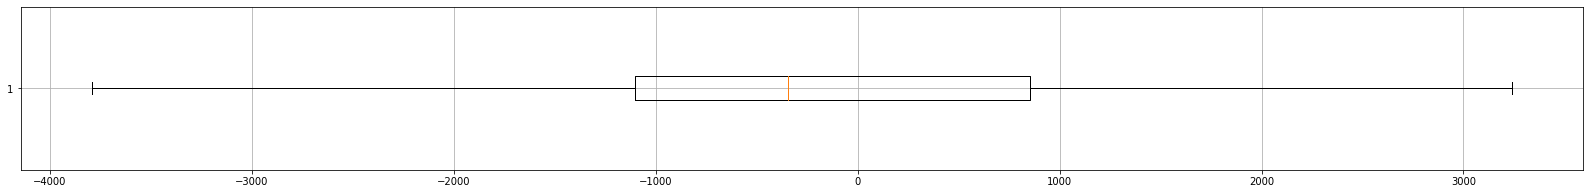

In [68]:
plt.figure(figsize = (28, 3))
plt.boxplot((Y_test - preds_test), vert = False)
plt.grid()
plt.show()

## Polinomial de segundo grado

### Entrenamiento

In [69]:
poly_features = PolynomialFeatures(degree = 2, include_bias = False)

In [70]:
X_poly_train = poly_features.fit_transform(X_train_scaled)

In [71]:
X_poly_test = poly_features.fit_transform(X_test_scaled)

In [72]:
poly_reg_model = LinearRegression()

In [73]:
poly_reg_model.fit(X_poly_train, Y_train)

LinearRegression()

In [74]:
poly_reg_model.coef_

array([-6.15488946e+16,  1.21295588e+14,  1.57620210e+13, -8.36332683e+13,
       -1.19432941e+14,  9.10014598e+13,  4.97578801e+13,  3.01056186e+14,
        2.80470564e+14,  4.04166282e+14,  3.30130870e+14,  2.00383840e+14,
       -1.39299063e+14, -2.14285796e+14,  7.63345697e+13, -1.36101821e+14,
        2.33008469e+14,  4.50008291e+14,  5.07416846e+14,  1.51606484e+14,
       -2.63117216e+14, -2.43981513e+14,  1.79605923e+14, -3.05809150e+13,
        1.01831007e+16,  7.47060040e+14,  9.70783544e+13, -5.15097655e+14,
       -7.35587990e+14, -9.53524188e+13, -2.24833899e+14, -1.76766538e+14,
       -2.81866537e+14, -7.94356719e+13, -3.23464356e+14, -1.54011597e+14,
       -3.79219866e+14, -7.62609822e+14,  4.23696460e+14,  4.41534003e+14,
        6.28609984e+14, -4.39027425e+14,  2.57642614e+14,  1.94223032e+14,
       -1.75917775e+14,  1.32555944e+14, -1.44411131e+14, -1.70976087e+14,
        4.14947266e+02, -1.13326562e+03,  2.30289062e+03,  5.36234375e+02,
       -1.32265625e+03, -

In [75]:
poly_reg_model.intercept_

-8492412706536037.0

### Evaluando el modelo

In [76]:
poly_preds_train = poly_reg_model.predict(X_poly_train)
poly_preds_test = poly_reg_model.predict(X_poly_test)

In [77]:
mean_absolute_error(Y_train, poly_preds_train), mean_absolute_error(Y_test, poly_preds_test)

(761.693493150685, 361059718541190.1)

In [78]:
np.sqrt(mean_squared_error(Y_train, poly_preds_train)), np.sqrt(mean_squared_error(Y_test, poly_preds_test))

(936.0769775380187, 1782923762268269.0)

### Analisis del error

In [79]:
(Y_test - poly_preds_test).describe(percentiles = [.25, .5, .75, .95, .99])

count    1.470000e+02
mean     1.516550e+14
std      1.782536e+15
min     -7.476918e+15
25%     -1.287000e+03
50%     -3.100000e+01
75%      9.740000e+02
95%      2.506000e+03
99%      9.597506e+15
max      1.221230e+16
Name: cnt, dtype: float64

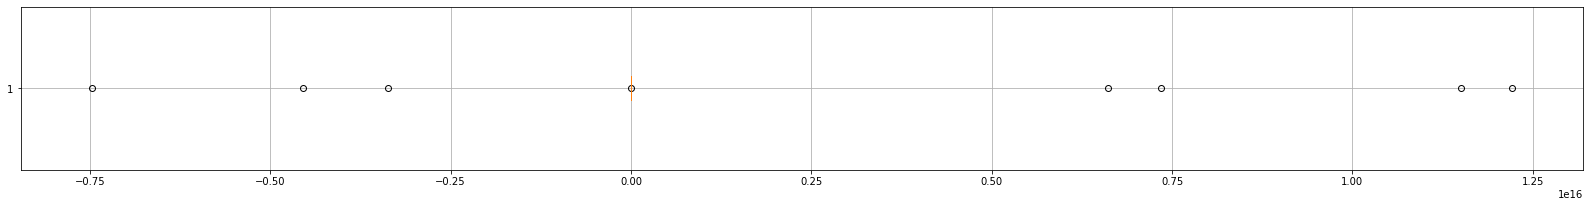

In [80]:
plt.figure(figsize = (28, 3))
plt.boxplot((Y_test - poly_preds_test), vert = False)
plt.grid()
plt.show()

## Polinomial de tercer grado

### Entrenamiento

In [81]:
poly_features3 = PolynomialFeatures(degree = 3, include_bias = False)

In [82]:
X_poly_train3 = poly_features3.fit_transform(X_train_scaled)

In [83]:
X_poly_test3 = poly_features3.fit_transform(X_test_scaled)

In [84]:
poly_reg_model3 = LinearRegression()

In [85]:
poly_reg_model3.fit(X_poly_train3, Y_train)

LinearRegression()

In [86]:
poly_reg_model3.coef_

array([  2.02835999, 297.47005865, 416.96406665, ...,   6.69896129,
        -8.6306421 ,  48.54515268])

In [87]:
poly_reg_model3.intercept_

4494.4656946743935

### Evaluando el modelo

In [88]:
poly_preds_train3 = poly_reg_model3.predict(X_poly_train3)
poly_preds_test3 = poly_reg_model3.predict(X_poly_test3)

In [89]:
mean_absolute_error(Y_train, poly_preds_train3), mean_absolute_error(Y_test, poly_preds_test3)

(2.97657058818253e-11, 9424.224631575367)

In [90]:
np.sqrt(mean_squared_error(Y_train, poly_preds_train3)), np.sqrt(mean_squared_error(Y_test, poly_preds_test3))

(4.113527132750333e-11, 15852.305276490823)

### Analysis del error

In [91]:
(Y_test - poly_preds_test3).describe(percentiles = [.25, .5, .75, .95, .99])

count      147.000000
mean       193.789086
std      15905.312753
min     -95147.824659
25%      -5105.447661
50%        798.415197
75%       4858.078543
95%      24342.882922
99%      47446.191286
max      57386.085169
Name: cnt, dtype: float64

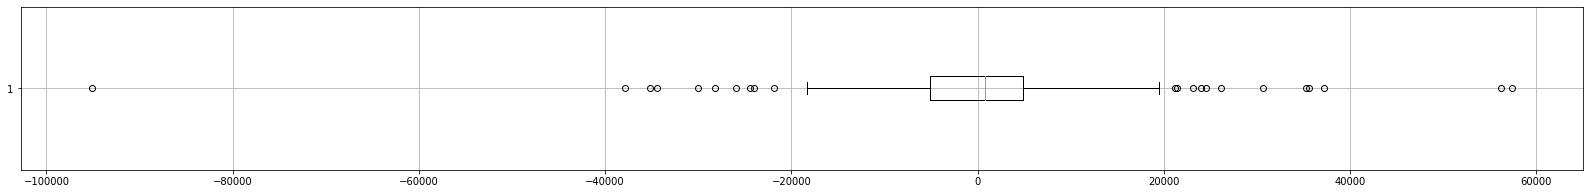

In [92]:
plt.figure(figsize = (28, 3))
plt.boxplot((Y_test - poly_preds_test3), vert = False)
plt.grid()
plt.show()

## Regularización Ridge

### Entrenamiento

In [102]:
ridge = Ridge(alpha=0.1, solver="cholesky")
ridge.fit(X_poly_train, Y_train)

Ridge(alpha=0.1, solver='cholesky')

### Evaluando el modelo

In [103]:
ridge_preds_train = ridge.predict(X_poly_train)
ridge_preds_test = ridge.predict(X_poly_test)

In [104]:
mean_absolute_error(Y_train, ridge_preds_train), mean_absolute_error(Y_test, ridge_preds_test)

(739.1501022931858, 1301.930618754024)

In [105]:

np.sqrt(mean_squared_error(Y_train, ridge_preds_train)), np.sqrt(mean_squared_error(Y_test, ridge_preds_test))

(912.2886517605857, 1788.2435514335114)

# **Interpretación**

**¿Cuáles son las 3 variables más importantes para la predicción de la cantidad de usuarios?**

Las 3 variables más importantes para la predicción de la cantidad de usuarios de acuerdo a los coeficientes arrojados por la regresión lineal son en orden: Feel_ Temp (7.24e+10), Temp (3.30e+10), Month October (1.94e+10). De acuerdo a esto la temperatura, la sensación térmica y que sea octubre es lo que más impacta a la cantidad de usuarios que tomarán el servicio de patinetas.

**Describa cual es el escenario ideal para el incremento de usuarios**

De acuerdo a los coeficientes de cada feature de la regresión lineal, el escenario ideal para el incremento de usuarios es un miércoles cálido de octubre con poco viento.

**¿Qué pasos adicionales deberían tener en cuenta para una próxima
iteración/mejora del modelo?**

Adicionar features relacionadas con las tarifas del servicio de patinetas en los diferentes días, meses u horas. Información sobre el tráfico de la ciudad en diferentes horas y días. Usar preferiblemente datos históricos para elaborar el modelo predictivo de una ciudad con características de urbanistica, transporte público y tráfico similares a la de la ciudad de la que queremos predecir la demanda de patinetas al día.
